# **Machine Learning Project**

Dataset: Mobile Price Classification

Link: https://www.kaggle.com/datasets/iabhishekofficial/mobile-price-classification

# Imports

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Dataset

In [73]:
df = pd.read_csv('train.csv')

In [74]:
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


# Pre-processing

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

In [76]:
# Looking for binary columns
binary_col = df.columns[df.nunique() <= 2]

for i in binary_col:
    print(i)

blue
dual_sim
four_g
three_g
touch_screen
wifi


In [77]:
# Checking if any column has just one unique value
df.columns[df.nunique() == 1]

Index([], dtype='object')

### Boxplot

In [78]:
# Function to create the boxplots
def create_boxplot(feature):
    sns.boxplot(data = df, x = 'price_range', y = feature)
    plt.xlabel('price_range', fontsize = 10)
    plt.ylabel(feature, fontsize = 10)

In [79]:
# Non-binary cols
non_binary_cols = [col for col in df.columns if col not in binary_col]
non_binary_cols.remove('price_range')
non_binary_cols

['battery_power',
 'clock_speed',
 'fc',
 'int_memory',
 'm_dep',
 'mobile_wt',
 'n_cores',
 'pc',
 'px_height',
 'px_width',
 'ram',
 'sc_h',
 'sc_w',
 'talk_time']

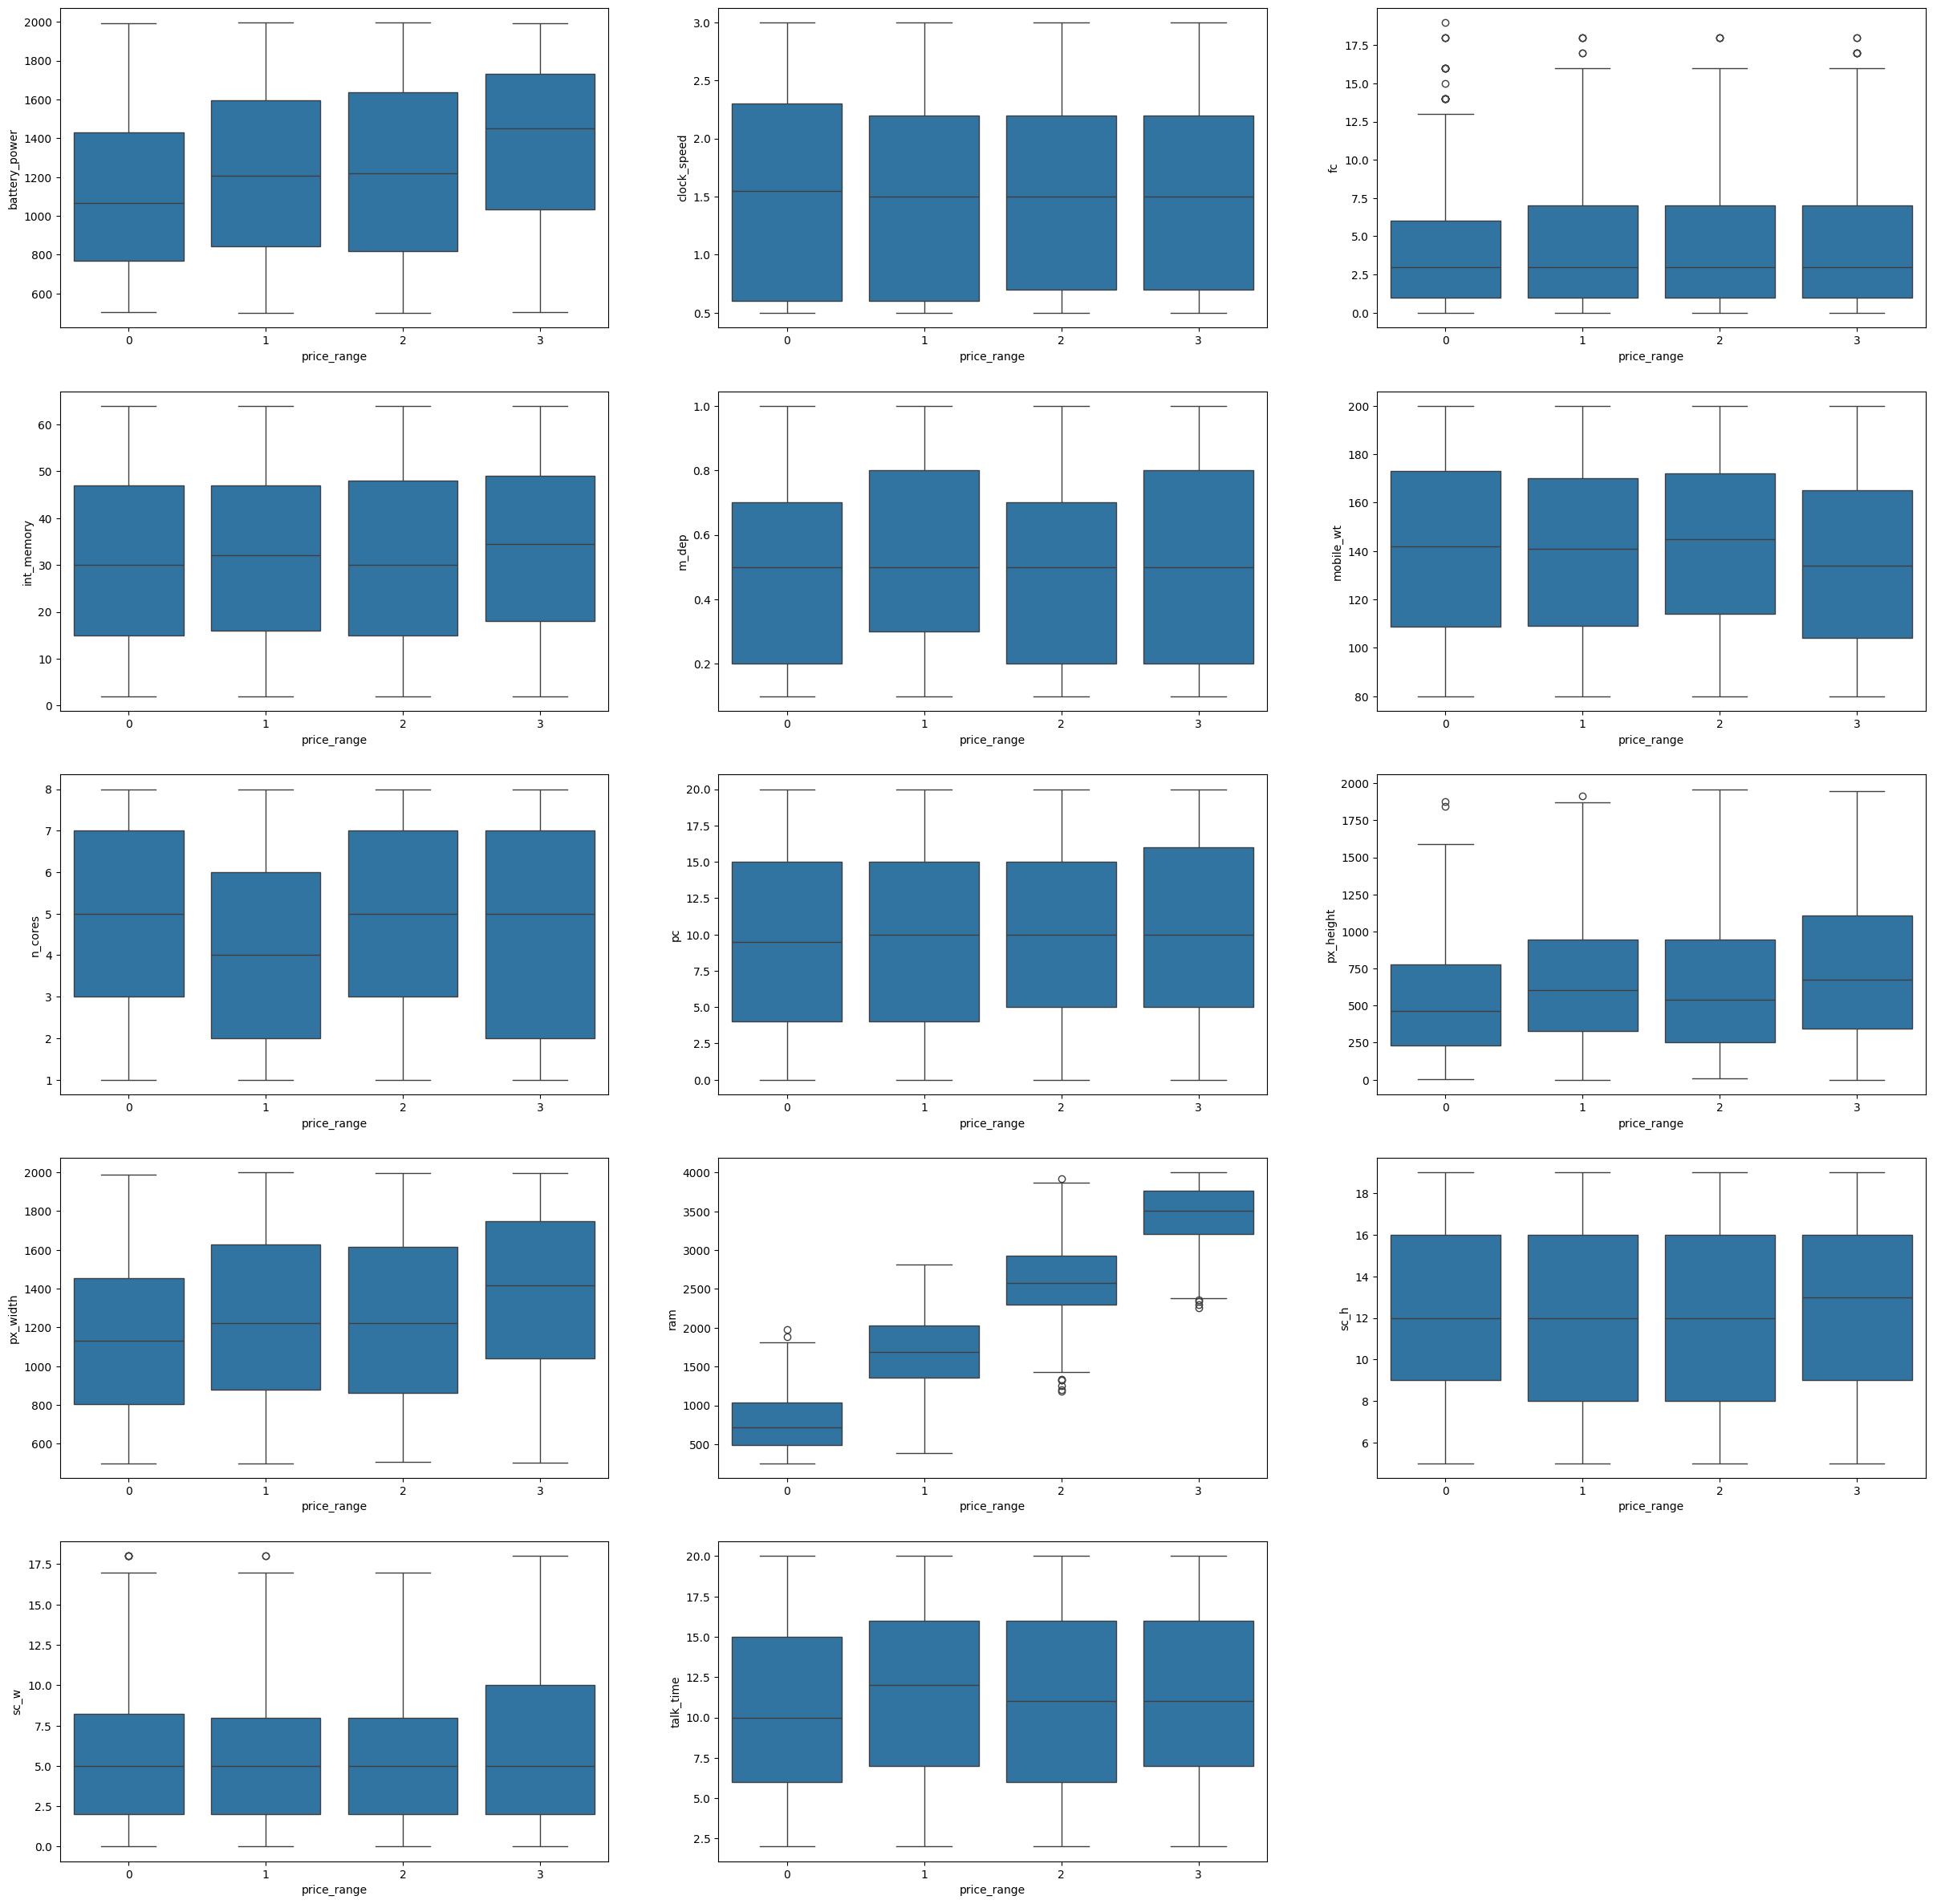

In [80]:
plt.figure(figsize=(30, 30))

temp = 1
for col in df[non_binary_cols]:
    plt.subplot(5,3,temp)
    create_boxplot(col)
    temp += 1
plt.show()


In [81]:
# Excluding outliers
for x in ['px_height', 'fc', 'sc_w', 'ram']:
    for y in df['price_range'].unique():
        q75 = df[x][df['price_range'] == y].quantile(0.75)
        q25 = df[x][df['price_range'] == y].quantile(0.25)
        intr_qr = q75-q25
    
        max = q75+(1.5*intr_qr)
        min = q25-(1.5*intr_qr)

        df = df.drop(df[(df['price_range'] == y) & ((df[x] > max) | (df[x] < min))].index)

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1955 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  1955 non-null   int64  
 1   blue           1955 non-null   int64  
 2   clock_speed    1955 non-null   float64
 3   dual_sim       1955 non-null   int64  
 4   fc             1955 non-null   int64  
 5   four_g         1955 non-null   int64  
 6   int_memory     1955 non-null   int64  
 7   m_dep          1955 non-null   float64
 8   mobile_wt      1955 non-null   int64  
 9   n_cores        1955 non-null   int64  
 10  pc             1955 non-null   int64  
 11  px_height      1955 non-null   int64  
 12  px_width       1955 non-null   int64  
 13  ram            1955 non-null   int64  
 14  sc_h           1955 non-null   int64  
 15  sc_w           1955 non-null   int64  
 16  talk_time      1955 non-null   int64  
 17  three_g        1955 non-null   int64  
 18  touch_screen 

### Normalization

In [83]:
# Using StandardScaler for nomalization of the numerical columns
scaler = StandardScaler()
temp = scaler.fit(df[non_binary_cols])
df[non_binary_cols] = temp.transform(df[non_binary_cols])

df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,-0.897750,0,0.823646,0,-0.761941,0,-1.390589,0.339351,1.352118,-1.104632,...,-1.416485,-1.146140,0.379933,-0.789415,0.281748,1.468233,0,0,1,1
1,-0.489290,1,-1.253595,1,-1.006377,1,1.154710,0.686698,-0.117296,-0.667209,...,0.608372,1.723965,0.455734,1.114432,-0.638197,-0.734539,1,1,0,2
2,-1.534400,1,-1.253595,1,-0.517505,1,0.490719,1.381390,0.137026,0.207636,...,1.427466,1.090305,0.429850,-0.313453,-0.868183,-0.367410,1,1,0,2
3,-1.415741,1,1.190218,0,-1.006377,0,-1.224591,1.034044,-0.258586,0.645058,...,1.319932,1.253379,0.583300,0.876451,0.511734,-0.000282,1,0,0,2
4,1.336228,1,-0.398260,0,2.171294,1,0.656717,0.339351,0.023994,-1.104632,...,1.301628,-0.083829,-0.672031,-1.027395,-0.868183,0.733976,1,1,0,1


### Heatmap

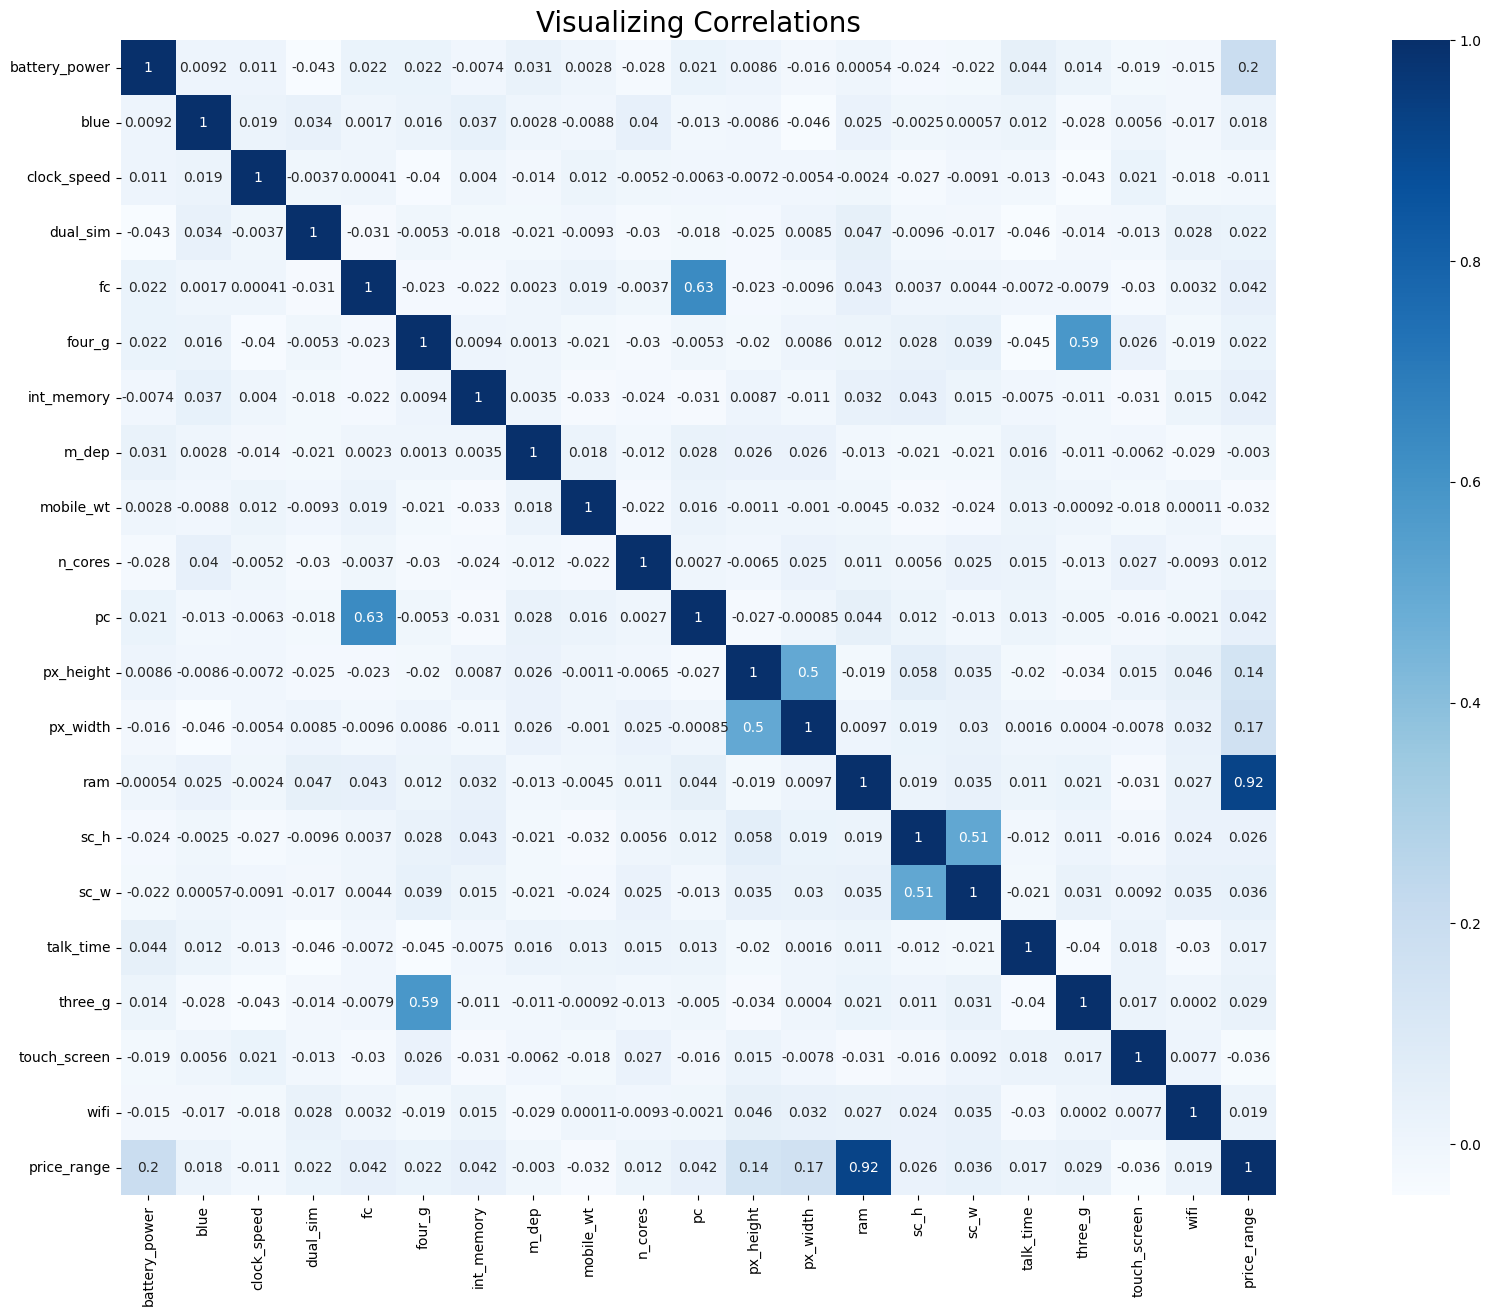

In [84]:
plt.figure(figsize = (30, 15))
sns.heatmap(df.corr(), cmap = 'Blues', square = True, annot = True)
plt.title("Visualizing Correlations", size = 20)
plt.show()

### Splitting Train and Test

In [85]:
X = df.drop('price_range', axis=1)
y = df['price_range']

In [86]:
random_state = 2

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=random_state,
                                                    shuffle=True,
                                                    stratify=y)

# Models

In [88]:
preds = []

In [89]:
# SKF for cross validation in grid search
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

# Mutual Information for Feature Selection
mi = SelectKBest(mutual_info_classif, k=10)

In [90]:
# Function to display the confusion matrix
def cm_display(pred):
    cm = confusion_matrix(y_test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    return disp.plot()

## SVM

In [91]:
# Define the parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Create the Support Vector Machine (SVM) classifier
svm_classifier = SVC(random_state=random_state)

# Initialize GridSearchCV with the model and parameter grid
grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=skf)

# Fit the model with all possible combinations of hyperparameters
svm = Pipeline([('mi', mi),
                ('gridsearch', grid_search)])
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)
preds.append(svm_pred)

In [92]:
print('Grid Search Best Parameters:', grid_search.best_params_)

Grid Search Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}


In [93]:
print(classification_report(y_test, svm_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       120
           1       0.95      0.95      0.95       123
           2       0.94      0.93      0.93       123
           3       0.95      0.98      0.96       123

    accuracy                           0.96       489
   macro avg       0.96      0.96      0.96       489
weighted avg       0.96      0.96      0.96       489



## Random Forest

In [94]:
# Define the parameter grid for Random Forest
param_grid = {'criterion': ['gini', 'entropy', 'log_loss'],
              'class_weight' : ['balanced', 'balanced_subsample', None],
              'max_features': ['sqrt','log2', None]
}

# Create the Random Forest classifier
forest = RandomForestClassifier(n_estimators = 100, random_state=random_state)

# Initialize GridSearchCV with the model and parameter grid
grid_search = GridSearchCV(estimator=forest, param_grid=param_grid, cv=skf)

# Fit the model with all possible combinations of hyperparameters
forest = Pipeline([('mi', mi),
                ('gridsearch', grid_search)])
forest.fit(X_train, y_train)
forest_pred = forest.predict(X_test)
preds.append(forest_pred)

In [95]:
print('Grid Search Best Parameters:', grid_search.best_params_)

Grid Search Best Parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt'}


In [96]:
print(classification_report(y_test, forest_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       120
           1       0.84      0.87      0.86       123
           2       0.84      0.77      0.81       123
           3       0.87      0.91      0.89       123

    accuracy                           0.87       489
   macro avg       0.87      0.87      0.87       489
weighted avg       0.87      0.87      0.87       489



## KNN

In [97]:
# Define the parameter grid for KNN
param_grid = {'weights': ['uniform', 'distance', None],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Create the KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=10)

# Initialize GridSearchCV with the model and parameter grid
grid_search = GridSearchCV(estimator=knn_classifier, param_grid=param_grid, cv=skf)

# Fit the model with all possible combinations of hyperparameters
knn = Pipeline([('mi', mi),
                ('gridsearch', grid_search)])
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
preds.append(knn_pred)

In [98]:
print('Grid Search Best Parameters:', grid_search.best_params_)

Grid Search Best Parameters: {'algorithm': 'auto', 'weights': 'distance'}


In [99]:
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           0       0.86      0.85      0.86       120
           1       0.63      0.68      0.66       123
           2       0.60      0.59      0.59       123
           3       0.81      0.78      0.80       123

    accuracy                           0.72       489
   macro avg       0.73      0.72      0.73       489
weighted avg       0.73      0.72      0.72       489



## Decision Tree

In [100]:
# Define the parameter grid for Decision Tree
param_grid = {'criterion': ['gini', 'entropy', 'log_loss'],
              'splitter': ['best', 'random'],
              'max_features': ['sqrt','log2', None]
}

# Create the KNN classifier
dt_classifier = DecisionTreeClassifier(random_state=random_state)

# Initialize GridSearchCV with the model and parameter grid
grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, cv=skf)

# Fit the model with all possible combinations of hyperparameters
dt = Pipeline([('mi', mi),
                ('gridsearch', grid_search)])
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
preds.append(dt_pred)

In [101]:
print('Grid Search Best Parameters:', grid_search.best_params_)

Grid Search Best Parameters: {'criterion': 'entropy', 'max_features': None, 'splitter': 'best'}


In [102]:
print(classification_report(y_test, dt_pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       120
           1       0.80      0.79      0.80       123
           2       0.79      0.76      0.78       123
           3       0.87      0.89      0.88       123

    accuracy                           0.83       489
   macro avg       0.83      0.83      0.83       489
weighted avg       0.83      0.83      0.83       489



# Results

## Confusion Matrix

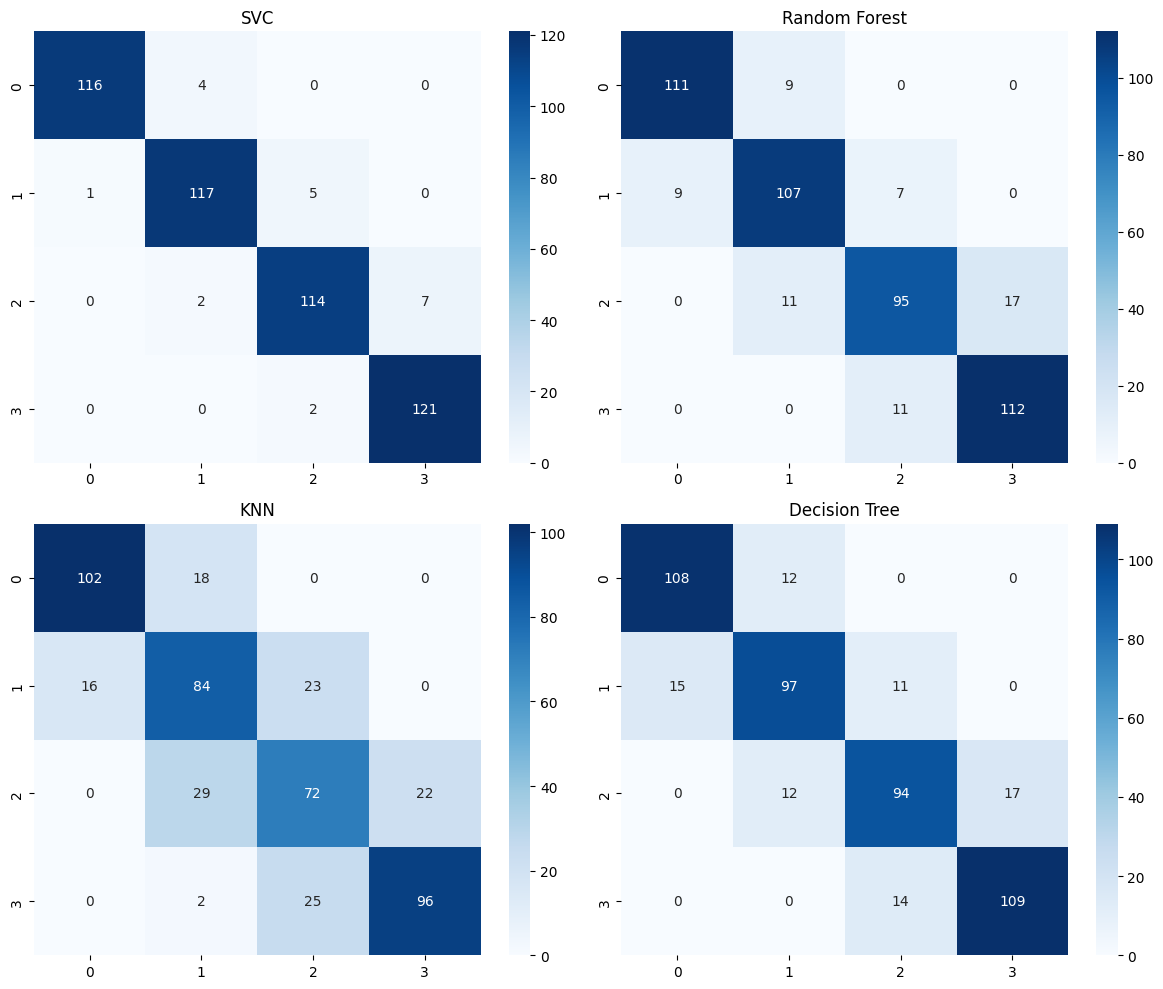

In [103]:
conf_matrices = [confusion_matrix(y_test, y_pred) for y_pred in preds]

# Plotting the confusion matrices as a grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# List of classifier names
classifier_names = ['SVC', 'Random Forest', 'KNN', 'Decision Tree']

for i, ax in enumerate(axes.flat):
    sns.heatmap(conf_matrices[i], annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(classifier_names[i])

plt.tight_layout()
plt.show()

In [104]:
from sklearn.metrics import accuracy_score

# Calculate accuracy for each classifier
accuracies = [accuracy_score(y_true, y_pred) for y_true, y_pred in zip([y_test]*len(classifier_names), preds)]

# Print the accuracy of each classifier
for name, acc in zip(classifier_names, accuracies):
    print(f'{name} Accuracy: {acc:.2f}')

SVC Accuracy: 0.96
Random Forest Accuracy: 0.87
KNN Accuracy: 0.72
Decision Tree Accuracy: 0.83
